# Working with SeismicBatch

## Content
* [Indexing data](#Indexing-data)
* [Actions](#Actions)
    * [Load](#Load)
    * [Visualization](#Visualization)
    * [Sorting](#Sorting)
    * [Signal processing](#Signal-processing)
    * [Export](#Export)
* [Utils](#Utils)
    * [Merging files](#Merging-files)

## Indexing data

Work with seismic data starts with data indexing. See the [tutorial](./index.ipynb) on index to recall different index types. Here we consider ```FieldIndex``` that enumerates field records of two files that we will refer as ```raw``` and ```lift```:

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt 

sys.path.append('..')

from seismicpro.batchflow import Dataset
from seismicpro.src import (SeismicBatch, SegyFilesIndex, FieldIndex,
                            TraceIndex, seismic_plot, spectrum_plot,
                            merge_segy_files, CustomIndex, gain_plot,
                            calculate_sdc_quality)
from tutorials_utils import load_speed, load_ix

path_raw = '/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy'
path_lift = '/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy'

field_index = (FieldIndex(name='raw',
                          extra_headers=['offset', 'INLINE_3D', 'CROSSLINE_3D'],
                          path=path_raw)
               .merge(FieldIndex(name='lift', path=path_lift)))

field_index.head()

,INLINE_3D,TraceNumber,offset,CROSSLINE_3D,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id
,,,,,raw,raw,lift,lift
FieldRecord,,,,,,,,
111906,1617,1656,35,550,1,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,1,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,1617,1657,36,551,2,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,2,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,1617,1655,78,549,3,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,3,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,1617,1658,79,552,4,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,4,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,1617,1654,127,548,5,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,5,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...


## Actions

### Load

Action ```load``` reads sets of traces from SEGY files and stores them in batch components. You can manage which components to load setting ```components``` parameter. Depending on batch index type each set of traces is represended by a signle trace (in case of ```TraceIndex```), or traces that correspond to a single field record (in case of ```FieldIndex```), or all traces from a single bin (in case of ```BinsIndex```) etc.

In each component items traces are loaded in the same order as rows in index DataFrame.

One can load not the whole trace but its specific slice. Use ```tslice``` parameter to specify which slice to load. For illustration, let's load first 3000 samples of each trace in ```raw``` and ```lift``` components:

In [2]:
batch = (Dataset(field_index, SeismicBatch).next_batch(10)
         .load(fmt='segy', components=('raw', 'lift'), tslice=slice(3000)))

Now batch contains 10 items in components ```raw``` and ```lift```. Traces in batch items have common field record id. Each trace is limited to 3000 samples.

In [3]:
batch.raw.shape, batch.lift.shape, batch.raw[0].shape

((10,), (10,), (3456, 3000))

In contrast, working with ```TraceIndex``` we will load single traces in batch items:

In [4]:
trace_batch = (Dataset(TraceIndex(field_index), SeismicBatch).next_batch(10)
              .load(fmt='segy', components=['raw', 'lift'], tslice=slice(3000)))

trace_batch.raw.shape, trace_batch.lift.shape, trace_batch.raw[0].shape

((10,), (10,), (1, 3000))

### Visualization

Below we illustrate vaious options for batch items visualization.

Show multiple traces of a single batch item with ```matplotlin.pyplot.imshow```:

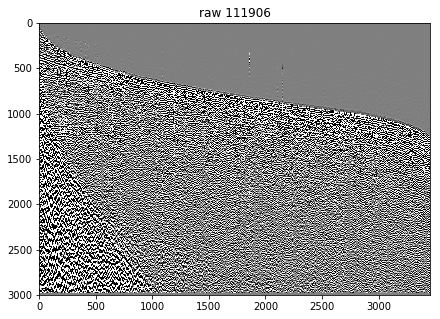

In [5]:
cv = 0.1
batch.seismic_plot('raw', batch.indices[0],
                   figsize=(7, 5), vmin=-cv, vmax=cv, cmap='gray')

Show multiple traces of several batch item with ```matplotlin.pyplot.imshow```:

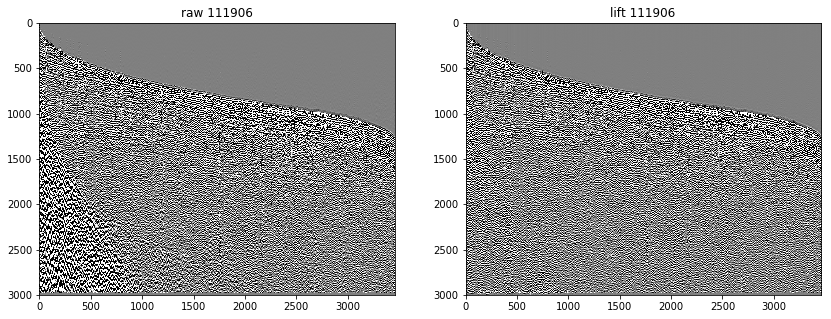

In [6]:
batch.seismic_plot(('raw', 'lift'), batch.indices[0], figsize=(14, 5),
                   vmin=-cv, vmax=cv, cmap='gray')

Show a specific region bounded by ```xlim``` and ```ylim``` parameters:

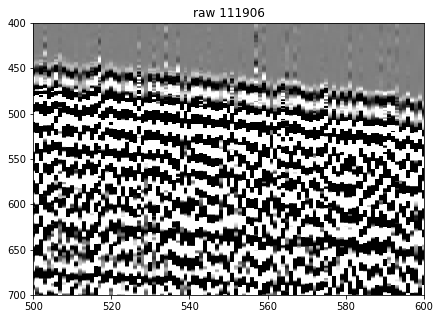

In [7]:
batch.seismic_plot('raw', batch.indices[0], xlim=(500, 600), ylim=(400, 700),
                   figsize=(7, 5), vmin=-cv, vmax=cv, cmap='gray')

Show a specific region bounded by ```xlim``` and ```ylim``` parameters in a **wingle** representation (use ```std``` parameter to control amptitudes):

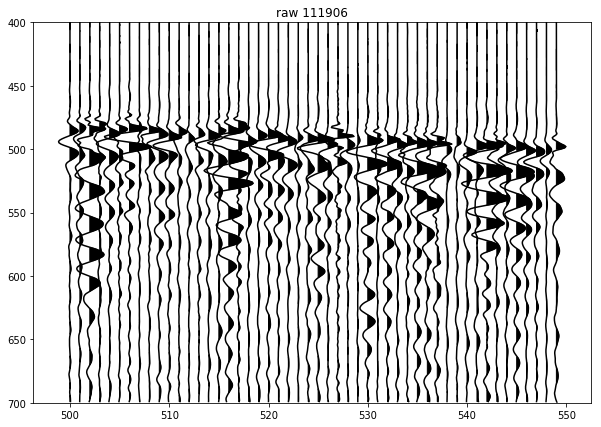

In [8]:
batch.seismic_plot('raw', batch.indices[0], wiggle=True, std=0.15,
                   xlim=(500, 550), ylim=(400, 700), figsize=(10, 7))

For batch item with a single trace ```seismic_plot``` visualize the trace with ```matplotlib.pyplot.plot``` function:

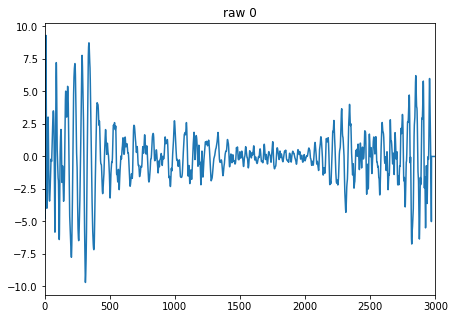

In [9]:
trace_batch.seismic_plot('raw', trace_batch.indices[0], figsize=(7, 5))

Signle trace can also be shows in the wingle form: 

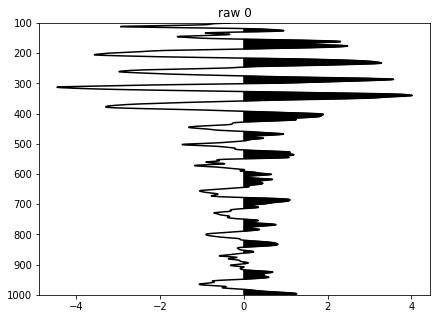

In [10]:
trace_batch.seismic_plot('raw', trace_batch.indices[0], wiggle=True,
                         ylim=(100, 1000), figsize=(7, 5))

To interactively iterate over batch items use ```items_viewer``` as follows:
```python
fig, tracker = batch.items_viewer('raw', vmin=-cv, vmax=cv, cmap='gray')
fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()
```

For investigation of signal power spectrum within selected regions use ```spectrum_plot```:

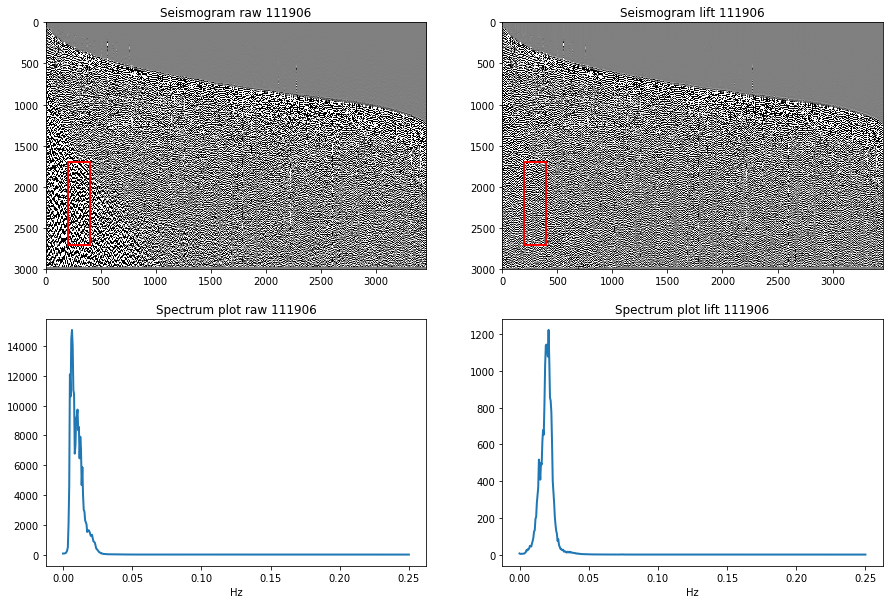

In [11]:
batch.spectrum_plot(('raw', 'lift'), batch.indices[0],
                    frame=(slice(200, 400), slice(1700, 2700)), 
                    max_freq=50, figsize=(15, 10),
                    vmin=-cv, vmax=cv, cmap='gray')

Show basic statistic such as dominant frequency (rms), standard deviation, total variation and mode in signal **time** domain:

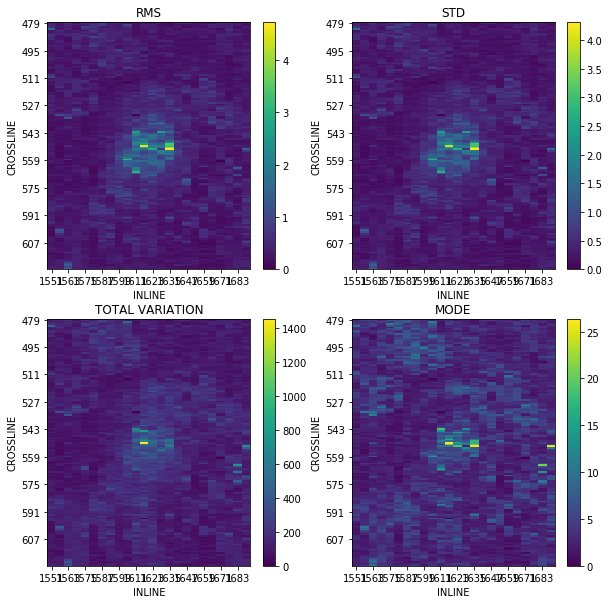

In [12]:
batch.show_statistics('raw', batch.indices[0], domain='time', figsize=(10, 10))

Show basic statistic in signal **frequency** domain:

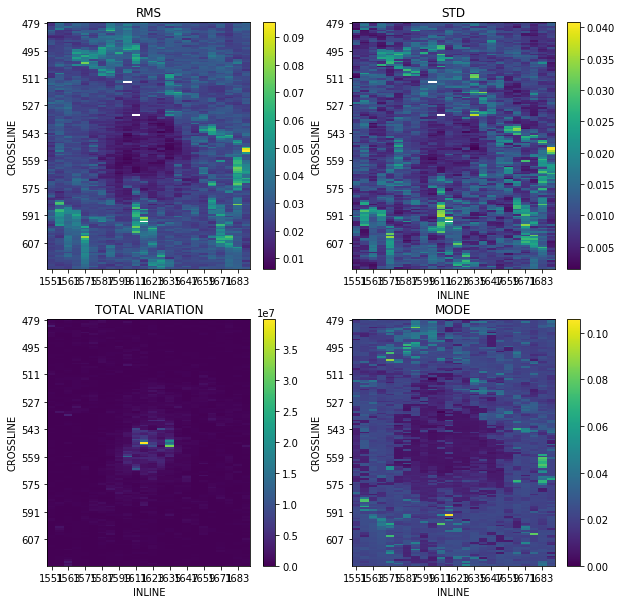

In [13]:
batch.show_statistics('raw', batch.indices[0],
                      domain='frequency', figsize=(10, 10))

### Sorting

Trace sorting order can be checked in components meta. By default, loaded traces have no specified order:

In [14]:
print(batch.meta['raw']['sorting'])

None


Trace sorting order can be changed by ```sort_traces``` action (note this action does not affect rows order in the index DataFrame):

In [15]:
batch.sort_traces(src='raw', dst='raw_sorted', sort_by='TraceNumber')

Check new sorting order:

In [16]:
batch.meta['raw_sorted']['sorting']

'TraceNumber'

Show traces in new sorting:

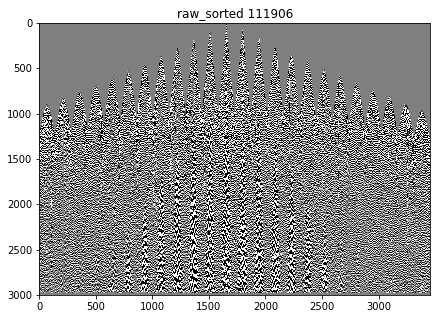

In [17]:
batch.seismic_plot('raw_sorted', 111906, figsize=(7, 5),
                   vmin=-cv, vmax=cv, cmap='gray')

### Signal processing

There is a number of built-in signal processing methods that can be applied to traces, e.g. Fourier transform, gradient or various wavelet transforms. E.g. consider gradient and Fourier transform:

In [18]:
batch.gradient(src='raw', dst='grad_raw')
batch.rfft(src='raw', dst='fft_raw')

Besides built-in methods, any custom fuction can be applied either to axix of batch item (```apply_along_axis```) or to the whole batch item (```apply_transform```). For exmaple, consider median filtration ```scipy.signal.medfilt```:

In [19]:
batch.apply_transform(medfilt, kernel_size=(9, 1), src='raw', dst='medfilt')

Show the filtered seismogram:

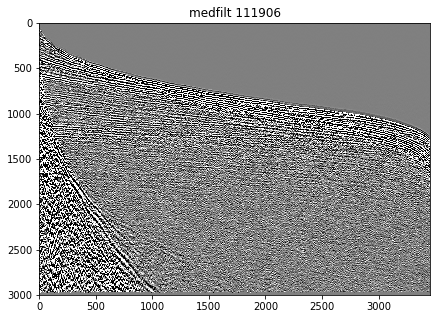

In [20]:
batch.seismic_plot('medfilt', 111906, figsize=(7, 5),
                   vmin=-cv, vmax=cv, cmap='gray')

### Field straightening
Field with CDP sorting needs to be straightened out before analysis in propuse to reduce normal addition. This process describes by the following equation:
$$\vartriangle t = t(0) \left(\left( 1 + \left( \frac{x}{V(t) t(0)}\right)\right)^{1/2} - 1\right) \ where,$$
* t(0) - time value with zero offset.
* V(t) - speed in moment t.
* x - offset.


Thus new amplitude value in the moment ```t``` and with offset ```x``` calculated as:
$$A(t,\ x) = A(t \ + \vartriangle t, \ x)$$

Load indices and speed values.

In [21]:
index = load_ix('../models/Inverse_traces/index_submodule.txt')
speed_conc = load_speed('../models/Inverse_traces/VEL_DEC2_4_11-13.txt', 3000)

Create ```CustomIndex``` with ```CDP``` as index column.

In [22]:
batch = (Dataset(CustomIndex((index), index_name='CDP'), SeismicBatch).p
         .load(components='raw', fmt='segy')
         .sort_traces(src='raw', dst='raw', sort_by='offset')
         .init_variable('diff', init_on_each_run=list)
         .field_straightening(speed=speed_conc, src='raw', dst='strainght', num_mean_tr=1)
         ).next_batch(2)

Let's draw two components and compare the difference.

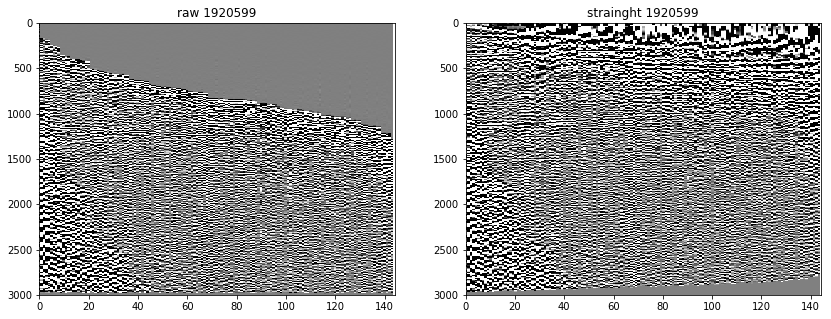

In [23]:
batch.seismic_plot(('raw', 'strainght'), batch.indices[0], figsize=(14, 5),
                   vmin=-cv, vmax=cv, cmap='gray')

Level lines are straightened on the right graph.

### Spherical divergence correction
The process when the amplitude of the signal on the seigmograms decreases with time named _spherical divergence_. To compensate this process the correction function - $g(t)$ is introduced and is determined by equation:
$$ g(t) = \frac{V_{rms}^{v_{pow}}(t) * t^{t_{pow}}}{V_0} \ where, $$
* $V_{rms}(t)$ - root mean square speed.
* t - time.
* $V_0$ - speed at time 0.
Here is $V_{pow}$ and $t_{pow}$ hyperparameters.

Then new amplitude value calculated as:
$$A_{new}(t) = A(t) * g(t)$$

Now let's have a look on the process with SeismicPro and first of all let's determine speed, time values and indices.

In [24]:
speed = np.array([1524]*700 + [1924.5]*300 + [2184.0]*400 +  [2339.6]*400 + 
                 [2676]*150 + [2889.5]*2250 + [3566]*2800 + [4785.3]*1000)
time = range(0, 2000)
sph_index = FieldIndex(name='raw', extra_headers='all', path='/notebooks/anton/spheare_difference/2_TAR_raw.sgy')

There are three oppunities to correct sperical divergence:
* Run spherical divergence correction with own values to hyperparameters.
* Find this hyperparameters with a built-in optimizer and use this parameters for all batch.
* Find hyperparameters for each field simultaneously.

consider each of them separately.

#### Own hyperparameters
For all this cases used ```correct_spherical_divergence``` action. To use own ```v_pow``` and ```t_pow``` values, argument ```find_params``` munst be _False_. Then add your own ```v_pow``` and ```t_pow``` values as an arguments.

In [25]:
batch = (Dataset(sph_index, SeismicBatch).next_batch(1)
         .load(fmt='segy', components='raw', tslice=slice(3000))
         .sort_traces(src='raw', dst='raw', sort_by='offset')
         .correct_spherical_divergence(src='raw', dst='corrected', time=time,
                                       speed=speed, find_params=False, v_pow=2, t_pow=1)
)

It will be useful to look at the difference between the original seismogram and the corrected one.

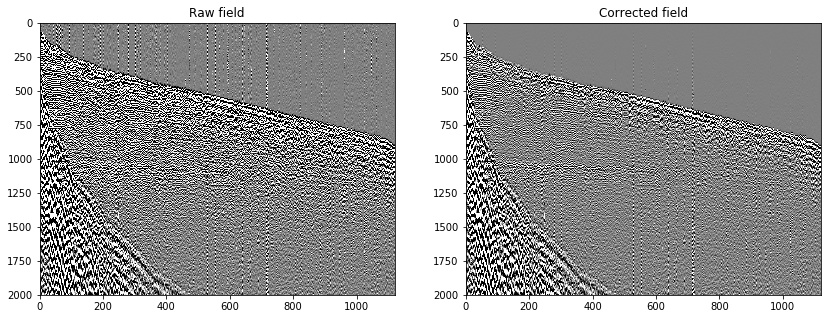

In [26]:
seismic_plot([batch.raw[0], batch.corrected[0]], vmin=-cv, vmax=cv,
             cmap='gray', figsize=(14, 5), names=['Raw field', 'Corrected field'])

More clear this difference shown on gain plot.

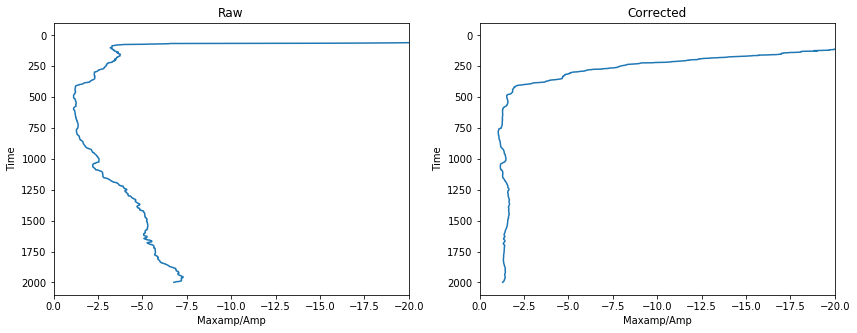

In [27]:
gain_plot([batch.raw[0], batch.corrected[0]], 51, names=['Raw', 'Corrected'], figsize=(14, 5), xbounds=(0, -20))

It's clear that the difference has narrowed since the correction was made.

#### Find hyperparameters with built-in optimizer
In order to apply this function to the whole batch, determine arguments for minimizer and add ```use_for_all=True```. Then the optimal parameters will be found for the first field and used for the rest fields.

In [28]:
batch_len = 1
batch = (Dataset(sph_index, SeismicBatch).next_batch(batch_len)
         .load(fmt='segy', components='raw', tslice=slice(3000))
         .sort_traces(src='raw', dst='raw', sort_by='offset')
         .add_components('comp', init=np.array([None] * batch_len))
         .correct_spherical_divergence(src='raw', dst='corrected', fun=calculate_sdc_quality,
                                       started_point=(2, 1), time=time, speed=speed,
                                       method='Powell', use_for_all=True, params_comp='comp')
)

In [29]:
print('Optimal parameters for v_pow is {:.3}, for t_pow is {:.3} '.format(*batch.comp))

Optimal parameters for v_pow is 2.66, for t_pow is 0.999 


Sesimograms before and after correction.

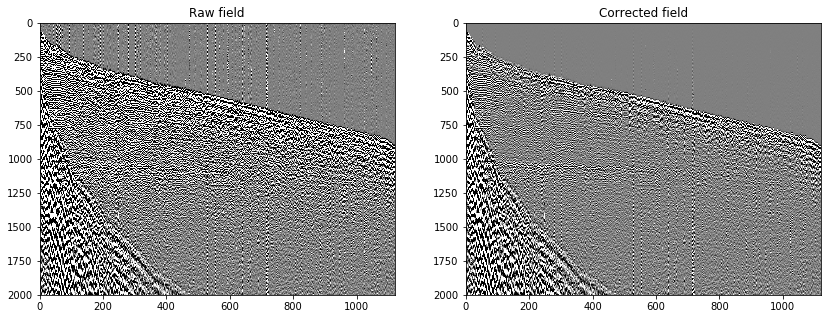

In [30]:
seismic_plot([batch.raw[0], batch.corrected[0]], vmin=-cv, vmax=cv,
              cmap='gray', figsize=(14, 5), names=['Raw field', 'Corrected field'])

Graph of the amplitude difference between raw and corrected data with optimal parameters.

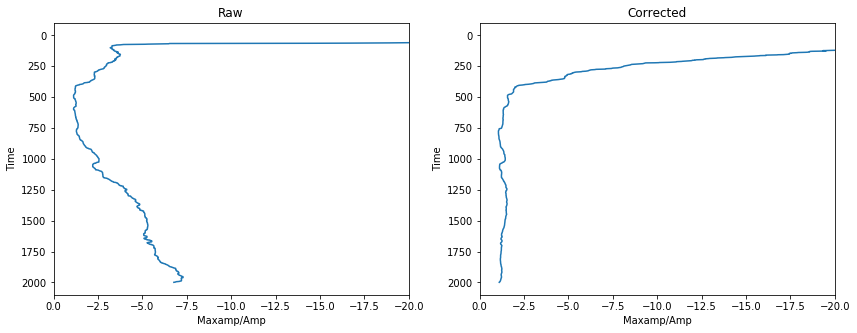

In [31]:
gain_plot([batch.raw[0], batch.corrected[0]], 51, names=['Raw', 'Corrected'], figsize=(14, 5), xbounds=(0, -20))

Another way is to find optimal parameters for each field. To do it use ```use_for_all=False```.

### Export

Data in batch components can be dumped in a number of formats:
 * SEGY file
 * first-break picking text file. 

There are two options for export in SEGY files: dump each component item in a separate file (parameter ```split=True```) or dump all traces in a single file (parameter ```split=False```). The next example demonstrates how to export field record in separate files:

In [32]:
dump_path = '/notebooks/egor/geolog/notebooks/dumps/'

batch.dump(fmt='segy', path=dump_path, src='raw', split=True);

## Utils

### Merging files

```merge_segy_files``` and ```merge_spicking_files``` allow merging of a set of files into one file. For examples, let's merge all SEGY files from the ```dump_path``` exploited above:

In [33]:
merge_segy_files(path=os.path.join(dump_path, '*sgy'),
                 output_path='/notebooks/egor/geolog/notebooks/merged.sgy')

Enjoy!